In [1]:
import netCDF4 as nc
import pylab as plt
import numpy as np
from mpl_toolkits.basemap import Basemap, shiftgrid
import cf
import cfplot as cfp
import matplotlib
import numpy.ma as MA

In [2]:
#constants
mr_ch4 = 16
per_sec_to_per_yr = 60*60*24*360
g_to_Tg = 1e12

## Import xltln data with emissions included

In [3]:
data = nc.Dataset('/shared/netscratch/ptg21/UM_data/xltln/xltln_ch4+oh.nc')
#extract variables to arrays
ch4_oh = data.variables['ch4+oh'][:] #moles per second
#lat = data.variables['latitude']
#lon = data.variables['longitude'][:]
#alt = data.variables['level_height'][:]

#ch4_oh, lon = shiftgrid(180.,ch4_oh,lon,start=False)

In [4]:
data_ch4 = nc.Dataset('/shared/netscratch/ptg21/UM_data/xltln/xltln_ch4.nc')
#extract variables to arrays
ch4 = data_ch4.variables['ch4'][:]
#lat = data.variables['latitude'][:]
#lon = data.variables['longitude'][:]
#alt = data.variables['level_height'][:]

#ch4, lon = shiftgrid(180.,ch4,lon,start=False)

In [5]:
press_xl_data = nc.Dataset('/shared/netscratch/ptg21/UM_data/xltln/xltln_p.nc')
press_xl = press_xl_data.variables['p']

In [6]:
trop_press_xl_data = nc.Dataset('/shared/netscratch/ptg21/UM_data/xltln/xltln_troppres.nc')
trop_press_xl = trop_press_xl_data.variables['trop_p']

In [7]:
mass_data = nc.Dataset('/shared/netscratch/ptg21/UM_data/xltln/xltln_airmass.nc')
mass = mass_data.variables['airmass_atm']

In [8]:
time = data.variables['time']
dtime = nc.num2date(time[:],time.units)

## Import fixed LBC data

In [20]:
data_lbc = nc.Dataset('/shared/netscratch/ptg21/UM_data/xgywn/xgywn_pm7-9.nc')
#extract variables to arrays
ch4_lbc = data_lbc.variables['field34009'][:]

ch4_oh_lbc = data_lbc.variables['field34341'][:]*3 #moles per sec
#lat_lbc = data_lbc.variables['latitude'][:]
#lon_lbc = data_lbc.variables['longitude'][:]
#box_no_lbc = data_lbc.variables['model_level_number'][:]
#alt_lbc = data_lbc.variables['hybrid_ht'][:]
mass_lbc = data_lbc.variables['field34363'][:]
press_lbc = data_lbc.variables['p']
trop_press_lbc = data_lbc.variables['p_3']

time_lbc = data_lbc.variables['t']
dtime_lbc = nc.num2date(time_lbc[:],time_lbc.units)

#ch4_lbc, lon_lbc = shiftgrid(180.,ch4_lbc,lon_lbc,start=False)

## Make tropospheric mask

In [21]:
trop_mask_xg = MA.masked_where(press_lbc < trop_press_lbc[:], press_lbc)

In [22]:
trop_mask_xl = MA.masked_where(press_xl < trop_press_xl[:][:,None,:,:], press_xl) #add extra dimension
#print(press_lbc)

## CH4 OH flux calc

In [23]:
#xltln
ch4_oh_tg_yr = ch4_oh*mr_ch4*per_sec_to_per_yr/g_to_Tg
ch4_oh_trop_xl = MA.masked_where(trop_mask_xl.mask,ch4_oh_tg_yr)
#sum over lat lon alt
flux_sum_xl = np.sum(ch4_oh_trop_xl, axis=(1,2,3))

Text(0.5, 1.0, 'CH4 OH flux over time (xltln)')

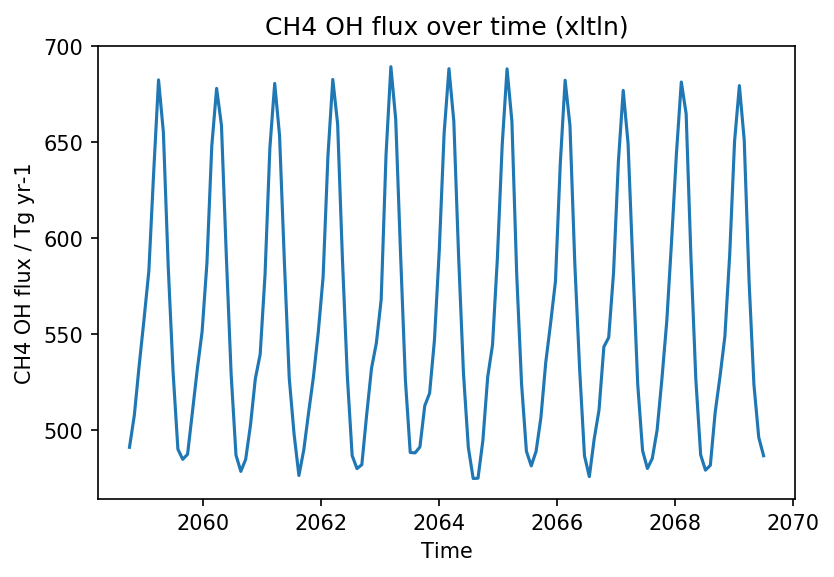

In [24]:
fig = plt.figure(dpi=150)
ax = plt.axes()
ax.plot(dtime,flux_sum_xl)
plt.xlabel('Time')
plt.ylabel('CH4 OH flux / Tg yr-1')
plt.title(f'CH4 OH flux over time (xltln)')

In [25]:
#xgywn
ch4_oh_lbc_tg_yr = ch4_oh_lbc*mr_ch4*per_sec_to_per_yr/g_to_Tg
ch4_oh_trop_xg = MA.masked_where(trop_mask_xg.mask,ch4_oh_lbc_tg_yr)
#sum over lat lon alt
flux_sum_xg = np.sum(ch4_oh_trop_xg, axis=(1,2,3))

Text(0.5, 1.0, 'CH4 OH flux over time (xgywn)')

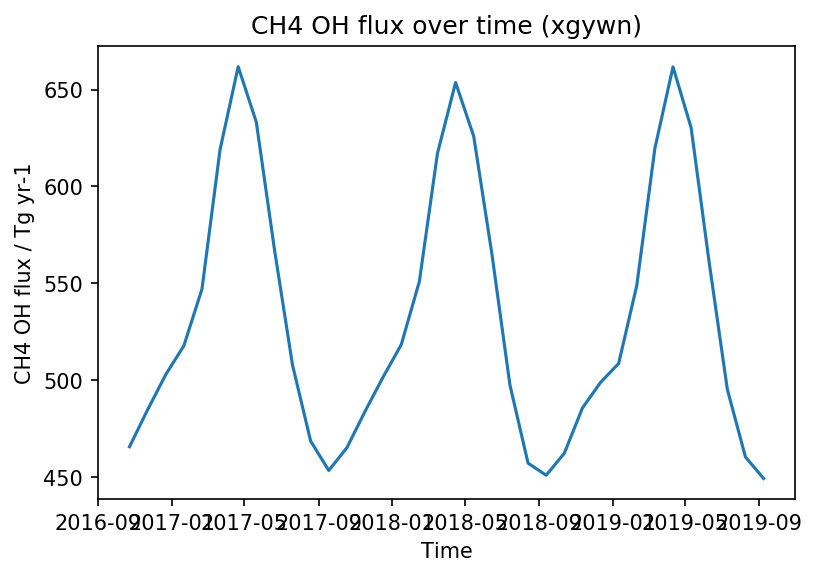

In [26]:
fig = plt.figure(dpi=150)
ax = plt.axes()
ax.plot(dtime_lbc,flux_sum_xg)
plt.xlabel('Time')
plt.ylabel('CH4 OH flux / Tg yr-1')
plt.title(f'CH4 OH flux over time (xgywn)')

## Burden calcs

In [27]:
#xltln burden calc
ch4_kg = np.multiply(mass,ch4) #ch4 in kg
bur_1 = ch4_kg.sum(axis=(1,2,3))/1e9 # sum over lat, lon, alt

#xgywn burden calc
ch4_lbc_kg = np.multiply(mass_lbc,ch4_lbc)
bur_lbc = ch4_lbc_kg.sum(axis=(1,2,3))/1e9

## Lifetime calc

In [28]:
t_ch4_xl = bur_1/flux_sum_xl
t_ch4_xg = bur_lbc/flux_sum_xg

In [36]:
lifetime_xl = np.mean(t_ch4_xl)
lifetime_xg = np.mean(t_ch4_xg)
print(f'Emissions lifetime: {lifetime_xl:.1f} years')
print(f'LBC lifetime: {lifetime_xg:.1f} years')

Emissions lifetime: 8.7 years
LBC lifetime: 9.2 years


Text(0.5, 1.0, 'CH4 lifetime (xltln)')

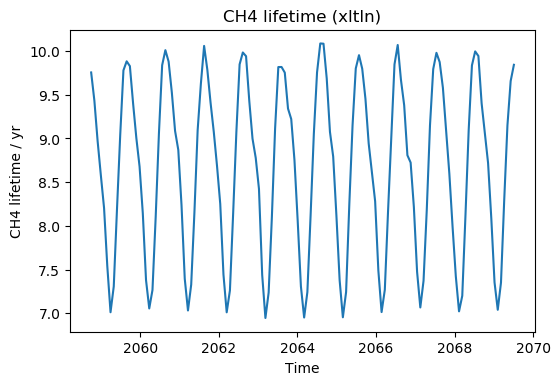

In [29]:
fig = plt.figure(dpi=100)
ax = plt.axes()
ax.plot(dtime,t_ch4_xl)
plt.xlabel('Time')
plt.ylabel('CH4 lifetime / yr')
plt.title(f'CH4 lifetime (xltln)')

Text(0.5, 1.0, 'CH4 lifetime (xgywn)')

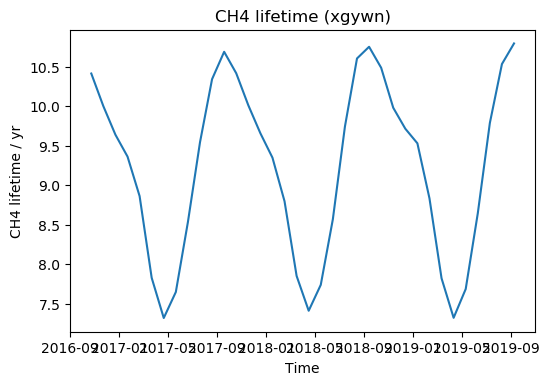

In [30]:
fig = plt.figure(dpi=100)
ax = plt.axes()
ax.plot(dtime_lbc,t_ch4_xg)
plt.xlabel('Time')
plt.ylabel('CH4 lifetime / yr')
plt.title(f'CH4 lifetime (xgywn)')